# Statistical Prediction/Projection via Multilinear Regression 

(Author: Lina Boljka)

This code shows how we used the multilinear regression for statistical prediction/projection in Omrani et al. (2022) [doi:NPJCLIMATSCI-00698].

Short guide to the code: First, we provide the functions that can be run below under section "RUN FUNCTIONS". So if functions are of interest feel free to check them out, but their parameters and all the other work is done below in "RUN FUNCTIONS", and "PLOT". To change parameter of interest simply change them under "RUN FUNCTIONS" and see their result in "PLOT". For all this to work - run the functions first (e.g. select "Kernel" tab above and run "Restat & Run All").

--------------------------------------------------------------------

### IMPORT LIBRARIES

In [1]:
# ----
# IMPORT RELEVANT LIBRARIES
# ----
#!pip install numpy
import numpy as np
#!pip install pandas
import pandas as pd
#!pip install xarray
import xarray as xr 
# ----
#!pip install scipy
from scipy.stats import linregress
from scipy import stats
from scipy import signal

# ----
#!pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# ----
#!pip install -U scikit-learn
from sklearn.linear_model import LinearRegression

# ----
#!pip install pycwt
import pycwt as wavelet
from pycwt.helpers import find


### GET PREDICTAND

Load data you want to predict - choose from:

- Surface temperature averaged over Europe (TsfcEU) [JFM mean; 10W-30E, 45N-85N] - linearly detrended (select linnonlin = '' below)
- Surface temperature averaged over Southern Europe (TsfcSEU) [JFM mean; 10W-30E, 35N-50N] - linearly detrended (select linnonlin = '' below)
- Surface temperature averaged over Northern Europe (TsfcNEU) [JFM mean; 10W-30E, 50N-85N] - linearly detrended (select linnonlin = '' below)
- Surface temperature averaged over Eurasia (TsfcEAS) [JFM mean; 10W-130E, 45N-85N] - linearly detrended (select linnonlin = '' below)
- Surface temperature averaged globally (TsfcGlob) [JFM mean] - quadratically detrended (select linnonlin = 'quadr' below)
- Surface temperature averaged globally (TsfcGlobAnnual) [Annual mean] - quadratically detrended (select linnonlin = 'quadr' below)
- Precipitation averaged over Southern Europe (PrecipSEU) [JFM mean; 10W-30E, 35N-50N] - linearly detrended (select linnonlin = '' below)
- Precipitation averaged over Northern Europe (PrecipNEU) [JFM mean; 30W-30E, 50N-85N] - linearly detrended (select linnonlin = '' below)
- Atlantic Multidecadal Oscillation/Variability (AMO) [JFM mean; 75W-7.5W, 0N-60N] - linearly detrended (select linnonlin = '' below)
- North Atlantic Oscillation (NAO) [JFM mean; 90W-40E, 20N-80N] - linearly detrended - linearly detrended (select linnonlin = '' below)
- Sea ice (Ice) [JFM mean; 60W-50E, 50N-90N] - linearly detrended (select linnonlin = '' below)
- Sea ice (Ice) [JFM mean; 60W-50E, 50N-90N] - quadratically detrended (select linnonlin = 'quadr' below)

Note that for surface temperature linnonlin = 'quadr' is also an option, 
but the trend over Eurasia/Europe was largely linear, whereas global-mean was quadratic (preselected).

In [2]:
# ----
# LOAD DATA - predictand
# ----
# generate function that can import/load timeseries of anomalies 
# ----
def import_predictand(variable = 'temperature', index = 3, linnonlin = ''):
    '''
    This function returns PredictandData (<array>) and its PredictandName (<str>). PredictandName can be: 
        for variable = 'temperature'  : [0]'TsfcEU', [1]'TsfcSEU', [2]'TsfcNEU', [3]'TsfcEAS',
                                                            [4]'TsfcGlob', [5]'TsfcGlobAnnual'
        for variable = 'precipitation': [0]'PrecipSEU', [1]'PrecipNEU'
        for variable = 'IceNAOAMO'    : [0]'Ice', [1]'NAO', [2]'AMO'
    ---
    Function takes in:
        variable  : <str> : specify which variable you want to predict, choose from:
                            'temperature', 'precipitation', 'IceNAOAMO'
        index     : <int> : specify index to PredictandName from above:
                            for 'temperature' index can vary from 0 to 5
                            for 'precipitation' index can vary from 0 to 1
                            for 'IceNAOAMO' index can vary from 0 to 2
        linnonlin : <str> : Specify if you would like to predict variable that had 
                            linear or quadratic trend removed. Values can be: 
                            = ''       for linearly detrended timeseries or 
                            = 'quadr'  for quadratically detrended 
                            NB: ~ for 'TsfcEU', 'TsfcSEU', 'TsfcNEU','TsfcEAS', 
                                    'PrecipSEU', 'PrecipNEU', 'NAO','AMO' 
                                  choose linear detrending, i.e. linnonlin = ''
                                ~ for 'TsfcGlob','TsfcGlobAnnual' choose linnonlin = 'quadr'
                                ~ for 'Ice' choose either one.
    Default inputs are for 'temperature', index 3, linearly detrended, i.e. for TsfcEAS.
    All data were computed for JFM mean (except for annual mean in TsfcGlobAnnual).   
    '''   
    
    path = 'txts/' # path to all txt data
    
    if variable == 'temperature':
        ## temperature timeseries (linear/quadratic detrending): JFM (except for "Annual") 1870-2019
        Tnames = ['TsfcEU', 'TsfcSEU', 'TsfcNEU','TsfcEAS','TsfcGlob','TsfcGlobAnnual'] 
        #                                       # names of variables stored in files listed below
        Tpaths = [path + 'HadCRUT18702019_TsfcEU_JFM2.no_' + linnonlin + 'trend.txt', 
                  path + 'HadCRUT18702019_TsfcSEU_JFM2.no_' + linnonlin + 'trend.txt', 
                  path + 'HadCRUT18702019_TsfcNEU_JFM2.no_' + linnonlin + 'trend.txt', 
                  path + 'HadCRUT18702019_TsfcEAS_JFM2.no_' + linnonlin + 'trend.txt', 
                  path + 'HadCRUT18702019_TsfcGlob_JFM2.no_' + linnonlin + 'trend.txt',
                  path + 'HadCRUT18702019_TsfcGlob_annual2.no_' + linnonlin + 'trend.txt'] 
        #                                       # paths/names of files with specific variables

        # load temperature data if you want to predict it 
        Ti = index # index to temperature data we are loading / are interested in - change as necessary
        PredictandData = np.loadtxt(Tpaths[Ti])
        PredictandName = Tnames[Ti]

    elif variable == 'precipitation':
        ## precipitation timeseries (linear detrending): JFM 1870-2014
        Pnames = ['PrecipSEU', 'PrecipNEU'] # names of variables stored in files listed below
        Ppaths = [path + 'NOAA20CR_precipSEU_JFM2.no_' + linnonlin + 'trend.txt', 
                  path + 'NOAA20CR_precipNEU_JFM2.no_' + linnonlin + 'trend.txt'] 
        #                                       # paths/names of files with specific variables

        # load precipitation data if you want to predict it 
        Pi = index # index to precipitation data we are loading / are interested in - change as necessary
        PredictandData = np.loadtxt(Ppaths[Pi])
        PredictandName = Pnames[Pi]

    else: # variable == 'IceNAOAMO'
        ## sea ice (linear detrending), sea ice (quadratic detrending), NAO & AMO (linear detrending): 
        #                                                                                #JFM 1870-2019
        IceNAOAMOnames = ['Ice','NAO','AMO']
        IceNAOAMOpaths = [path + 'COBE18702019_icec_JFM2.no_' + linnonlin + 'trend.txt',
                          path + 'HadSLP18702019_NAO_JFM3.no_' + linnonlin + 'trend.tser.txt',
                          path + 'HadISST18702019_sst_JFM2.no_' + linnonlin + 'trend.txt'] 
        #                 # paths/names of files with specific variables

        # load sea-ice/NAO/AMO data if you want to predict it as 
        IceNAOAMOi = index
        PredictandData = np.loadtxt(IceNAOAMOpaths[IceNAOAMOi])
        PredictandName = IceNAOAMOnames[IceNAOAMOi]
    
    return (PredictandData, PredictandName) # can be: = Tdata, = Pdata, = IceNAOAMOdata; 
    #                                                        # = Tname, = Pname, = IceNAOAMOname


### GET PREDICTORS

Load data you want to use to predict from, i.e. predictors. Choose at least one from:

- Atlantic Multidecadal Oscillation/Variability (AMO) [JFM mean; 75W-7.5W, 0N-60N] - linearly detrended (select linnonlin = '' below)
- North Atlantic Oscillation (NAO) [JFM mean; 90W-40E, 20N-80N] - linearly detrended - linearly detrended (select linnonlin = '' below)
- Sea ice (Ice) [JFM mean; 60W-50E, 50N-90N] - linearly detrended (select linnonlinIce = '' below) /select this or the one below/
- Sea ice (Ice) [JFM mean; 60W-50E, 50N-90N] - quadratically detrended (select linnonlinIce = 'quadr' below) /select this or the one above/
- Above-selected predictand (PredictandData, PredictandName)

Note that only one sea-ice should be chosen and if sea-ice is chosen it should be listed as the first predictor in the code below! 

In [3]:
# ----
# LOAD DATA - predictors
# ----

def import_predictors(PredictorsNames,PredictandName,PredictandData,linnonlin='',linnonlinIce=''):
    '''
    This function returns PredictorsData (<array of arrays>) and its PredictorsNames (<list of str>). 
    ---
    Function takes in:
        PredictorsNames : <list of str> : Specify which data we want to use as predictors
                                          => choose from 'Ice', 'NAO', 'AMO', and PredictandName
                                          => PredictandName comes from function "import_predictand"
                                          IMPORTANT: if PredictandName is 'Ice', 'NAO' or 'AMO'
                                                      we do NOT add it twice to PredictorsNames!!!!
                                                      (it can also be omitted in the input PredictorsNames,
                                                        but is also checked below just in case 
                                                        - this then updates the PredictorsNames list!)
        PredictandName  : <str>         : Provide predictand's name (output from "import_predictand")
                                          => used for cross-referencing in if-statements
        PredictandData  : <array>       : Provide predictand's data (output from "import_predictand")
                                          => if PredictandName is in PredictorsNames we use 
                                              PredictandData as predictor too so it must be specified,
                                              otherwise it is a dummy and random array can be input
        linnonlin       : <str>         : Specify if you would like to predict variable that had 
                                            linear or quadratic trend removed. Values can be: 
                                            = ''       for linearly detrended timeseries or 
                                            = 'quadr'  for quadratically detrended 
                                            This should typically remain as ''
        linnonlinIce    : <str>         : As linnonlin but for sea-ice 
                                            => this is actually more important as we typically used 
                                                both linearly and quadratically detrended sea-ice 
                                                ensembles for our predictions
                                            => vary this variable between '' and 'quadr'!!!
    All data were computed for JFM mean (except for annual mean in TsfcGlobAnnual, which can be a predictand).   
    '''    
    
    path = 'txts/' # path to all txt data
    
    ## load data
    # predictand data
    VariableData = PredictandData + np.zeros((len(PredictandData))) # to avoid overriding data
    # ice data
    IceData = np.loadtxt(path + 'COBE18702019_icec_JFM2.no_' + linnonlinIce + 'trend.txt')
    IceData = IceData[:len(VariableData)] # in case VariableData is shorter - shorten all data
    # NAO data
    NAOData = np.loadtxt(path + 'HadSLP18702019_NAO_JFM3.no_' + linnonlin + 'trend.tser.txt')
    NAOData = NAOData[:len(VariableData)] # in case VariableData is shorter - shorten all data
    NAOData = NAOData/np.nanstd(NAOData) # divide by standard deviation if it wasn't already
    # AMO data
    AMOData = np.loadtxt(path + 'HadISST18702019_sst_JFM2.no_' + linnonlin + 'trend.txt')
    AMOData = AMOData[:len(VariableData)] # in case VariableData is shorter - shorten all data
    
    ## generate array for Predictors Data & corresponding Names
    PredictorsData = []
    PredictorsNamesOut = []
    if 'Ice' in PredictorsNames:
        PredictorsData.append(IceData)
        PredictorsNamesOut.append('Ice')
    if 'NAO' in PredictorsNames:
        PredictorsData.append(NAOData)
        PredictorsNamesOut.append('NAO')
    if 'AMO' in PredictorsNames:
        PredictorsData.append(AMOData)
        PredictorsNamesOut.append('AMO')
    if (PredictandName in PredictorsNames) and (PredictandName not in ['Ice', 'NAO', 'AMO']):
        PredictorsData.append(VariableData)
        PredictorsNamesOut.append(PredictandName)
    PredictorsData = np.array(PredictorsData) # sea ice must be first if chosen
    
    return (PredictorsData,PredictorsNamesOut)


### GET TRENDS 

In [4]:
# ----
# LOAD DATA - trends
# ----
# timeseries of trends extrapolated into the future
# generate function that can import/load timeseries of trends
# ----
def import_trend(predictandname = 'TsfcEAS', linnonlin = ''):
    '''
    This function returns trend of the predictand (<array>). 
    ---
    Function takes in:
        predictandname  : <str> : specify which predictand we have; it can be: 
                                    'TsfcEU', 'TsfcSEU', 'TsfcNEU', 'TsfcEAS', 'TsfcGlob', 'TsfcGlobAnnual',
                                    'PrecipSEU', 'PrecipNEU', 'Ice','NAO', 'AMO'
                                    
        linnonlin       : <str> : Specify if you would like to predict variable that had 
                                    linear or quadratic trend removed. Values can be: 
                                    = ''       for linearly detrended timeseries or 
                                    = 'quadr'  for quadratically detrended 
                                    NB: ~ for 'TsfcEU', 'TsfcSEU', 'TsfcNEU','TsfcEAS', 
                                            'PrecipSEU', 'PrecipNEU', 'NAO','AMO' 
                                          choose linear detrending, i.e. linnonlin = ''
                                        ~ for 'TsfcGlob','TsfcGlobAnnual' choose linnonlin = 'quadr'
                                        ~ for 'Ice' choose either one.
    
    Default inputs are for 'TsfcEAS', linearly detrended.
    All data were computed for JFM mean (except for annual mean in TsfcGlobAnnual).   
    '''   
    
    ## set up correct filenames & variable names
    path = 'nc/' # path to all trend data (.nc data)
    if predictandname == 'Ice':
        filename = path + 'COBE18702019_icec_JFM2.no_' + linnonlin + 'trend_trend.nc'
        if linnonlin == 'quadr':
            varname = 'COBE_icec'
        else:
            varname = 'icec'
    elif predictandname == 'AMO':
        filename = path + 'HadISST18702019_sst_JFM2.no_' + linnonlin + 'trend_trend.nc'
        varname = 'sst'
    elif predictandname == 'NAO':
        filename = path + 'HadSLP18702019_NAO_JFM3.no_' + linnonlin + 'trend.tser_trend.nc'
        varname = 'slp'
    elif predictandname.find('Precip')>=0:
        if predictandname == 'PrecipSEU':
            filename = path + 'NOAA20CR_precipSEU_JFM2.no_' + linnonlin + 'trend_trend.nc'
        else: #predictandname == 'PrecipNEU'
            filename = path + 'NOAA20CR_precipNEU_JFM2.no_' + linnonlin + 'trend_trend.nc'
        varname = 'prate'
    else: #predictandname.find('Tsfc')>=0
        if predictandname.find('Annual')>=0:
            filename = path + 'HadCRUT18702019_TsfcGlob_annual2.no_' + linnonlin + 'trend_trend.nc'
        else:
            filename = path + 'HadCRUT18702019_' + predictandname + '_JFM2.no_' + linnonlin + 'trend_trend.nc'
        if predictandname.find('TsfcGlob')>=0:
            varname = 'HadCRUT_'+predictandname
        else:
            varname = 'tas_mean'
    print(filename,varname)

    ## load trend data
    nc = xr.open_mfdataset(filename)[[varname]]
    trend = nc[varname].values
    
    return (np.array(trend))


### WAVELET FILTER

In [5]:
def wavelet_filter(timeseries,freq_band):
    ''' 
    This function will compute smoothing for a given frequency band (default is 50-70 [years]) 
    within given timeseries. Function returns timeseries smoothed over the given frequency band.
    
    Imports are:
        timeseries:   <array>          : timeseries data we wish to smooth [assume: annual mean]
        freq_band :   <list of floats> : specify [high,low] frequency cut-off as a list (2 values)
                                            => used for making a band pass filter with a wavelet
        
    For more: 
    => follow wavelet transform tutorial from 
            http://regeirk.github.io/pycwt/tutorial.html#time-series-spectral-analysis-using-wavelets
    '''
    
    # -----
    # get wavelet parameters
    # -----
    dt = 1.                       # data is annual mean (different between two data points = 1 year)
    dat_notrend = timeseries      # input timeseries had to be detrended
    std = dat_notrend.std()       # Standard deviation
    dat_norm = dat_notrend / std  # Normalized dataset

    mother = wavelet.Morlet(6)
    #s0 = 2. * dt    # Starting scale, in this case 2 * 1 years = 2 years
    s0 = 1. * dt     # Starting scale, in this case 1 * 1 years = 1 year
    dj = 1. / 12.    # Twelve sub-octaves per octaves
    J = 7. / dj      # Seven powers of two with dj sub-octaves
    
    # -----
    # do wavelet transform
    # -----
    
    ## (1) do wavelet transform to get wavelet parameters, periodogram etc.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,mother) 
    #print(wave.shape,scales.shape,freqs.shape) # print parameters
    period = 1. / freqs # get period from frequency [from wavelet periodogram]
    
    ## (2) get the relevant frequency/period band (as specified) out of the data (in frequency 'space')
    sel = find((period >= freq_band[0]) & (period <= freq_band[-1])) 
    Cdelta = mother.cdelta
    #print(Cdelta) # should be 0.776
    
    ## (3) RECONSTRUCT FILTERED DATA ; use eqn 11/29 from Torrence & Compo 1998
    #print(wave.real.shape,scales.shape) # check params
    reconstruct = np.sum(wave.real[sel,:]/np.sqrt(scales[sel, None]),axis=0)
    reconstruct = (dj*np.sqrt(dt)/(Cdelta*np.pi**(-1./4.)))*reconstruct *std   
    #             # NB: Psi_o(0) = pi^(-1/4) - Table 1 in Torrence and Compo 1998 for Morlet!
    #             # NB2: data were multiplied by standard dev. to get units back to the data
    
    return (reconstruct)
          

### CREATE PREDICTION MODEL (FUNCTION) 

This is the function that we ultimately used for generating multi-linear regression based projections in Omrani et al. (2022). Parameters are defined within the function and procedure is commented, but for any additional questions you can contact me on lina.boljka@uib.no. In many places there are too many parameters that were not really used in this paper (but were used for some other projections later on, and those will become available in the future).

In [6]:
# ----
# GENERATE FUNCTION THAT WILL PRODUCE PREDICTION/PROJECTION FROM GIVEN VARIABLES
# ----
def prediction_model_1D_lin (predictand, predictors, names, caseName, year1, year2, 
                                         year5 = 2019, deltalag = 1, maxneglag = 10, 
                                         lagmax = 35, lagfreq = 1, DMY = 'yearly', 
                                         mmean = False, std = False, filt = 'low', order = 2, 
                                         fs = 1., highcut = 1./45., lowcut = 1./150.):
    '''
    The function takes in: 
        predictand : <array>           : index timeseries we prepared from data 
                                         (e.g. TsfcEAS, AMO, sea-ice index) 
                                         [for multidecadal data: use predictand for testing and training]
        predictors : <array of arrays> : timeseries we can use to predict the "predictand" 
                                         (e.g., sea ice, AMO, NAO, and predictand itself)
                                         [for multidecadal data: use predictors for testing and training 
                                                                                 & also future prediction]
        names      : <list of str>     : names of predictors (for plotting & cross-referencing)
        year1,2    : <ints>            : specify start and end year of the input data 
                                            corresponding to predictand, predictors
        year5      : <int>             : [default is 2019] specify start year for prediction within 
                                            the given array - use for lagged-ensemble predictions 
                                            => this returns data for each "ensemble member" separately
        caseName   : <str>             : specify which data we input.... e.g. for predicting 
                                                    sea ice from NAO say, e.g., 'IcefromNAO'
                                                    => used for saving data/plotting etc. <=> reference
                                                    
        <------- ADDITIONAL PARAMETERS (with defaults) no need to change for AMO-related studies) -------->
        
        deltalag  : <float>            : specify time difference between past timesteps 
                                         (typically = 1 month/year; for daily data, e.g., 1/30) 
                                          => used if more than one past timestep is used to predict data 
                                           (in years or months; for daily enter 1./30.) 
                                           (e.g. deltalag = 1 (month/year), then predict from timesteps 
                                                 at -1, -2, ..., -maxneglag [months/years])
                                          => this can also help us establish how many past timesteps 
                                                  we ultimately need to get an optimal prediction
                                                  |=> it requires additional loop below over different 
                                                      "maxneglag" but function can also just be 
                                                      rerun with a different maxneglag anyway
                                                  |=> right now this testing is not included below
        maxneglag  : <float>           : maximum negative lag/past timestep we use (in months/years), 
                                         i.e. for prediction we use past timesteps: 
                                            -1, -1 +(-deltalag), -1+(-2*deltalag),..., -1 +(-maxneglag)
        lagmax     : <float>           : specify maximum lead time you will consider (in months) 
                                         (for 1 day specify 1/30; for yearly data specify in years!)
                                         - i.e. how far in advance do I want to predict; 
                                         - e.g. if =3*12 months (3 years) - then we predict 3 years ahead 
        lagfreq    : <float>           : specify how often we want to test the skill score 
                                         (compute prediction at specific lead-time; in month/year)
                                          - This will allow me to compute prediction and its skill 
                                                  score (correlation) every lagfreq up to lagmax!
                                          - Note: first lead time is "+1"!
        DMY        : <str>             : takes values "daily" or "monthly" or "yearly" 
                                          for daily or monthly or yearly input data/timeseries!
                                          # DMY = dailymonthlyyearly from before
        mmean      : <bool>            : if set to True - compute monthly means from given data 
                                          (only executed if daily data was input otherwise a dummy)!
        std        : <bool>            : if set to True - divide input data by standard deviation
        filt       : <str>             : specify if we want low, high, band pass filter ; 
                                          ('band','low','high'); 
                                          - for high and low specify highcut only; 
                                          - for bandpass specify both, where 'low' must be a smaller number!
                                          NB: This is used for smoothing data to specific timescale
                                                and then computing RMSE/correlation skill score for it
        lowcut,    : <floats>          : set up low and high frequency cut-offs for butterworth filter       
        highcut                                           
        fs         : <float>           : the spacing between data (for yearly data fs = 1 (year))
                                
        order      : <int>             : specify order of Butterworth filter (default is 5 here)
            
    Import one index (predictand) at the time (but multiple predictors). 
                
    Function will compute multilinear regression model for predicting predictand, 
                            e.g. TsfcEAS, from various timeseries (predictors) data.
    Function returns: prediction of the predictand into the future (up to lagmax), 
                            correlation skill score and RMSE of raw and smoothed predicitons.
    Call function as (for example): 
        names = ['Ice','NAO','AMO','TsfcEAS']
        caseName = 'TsfcEAS'
        year1 = 1870
        year2 = 2019
        year5 = 2015
        set up predictand/predictors arrays elsewhere & keep other parameters as provided
        corrs, corrsfilt, rmse, rmsefilt, pred_data = prediction_model_1D_lin (predictand, 
                                                                    predictors, names, caseName, 
                                                                    year1, year2, year5)
    '''

    print('case', caseName) # which case are we computing?

    # set up butterworth filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if filt.find('band')>=0:
        bcoef, acoef = signal.butter(order, [low, high], btype=filt)
    else:
        bcoef, acoef = signal.butter(order, high, btype=filt)

    ## ==============================
    # first prepare data for predictand 
    
    # if we are generating lagged-ensembles then year5 is smaller than year2
    # then we should shorten the input dataset accordingly 
    # (so that predictions ultimately start at year5+1)
    if year2 > year5: # this only works for yearly data right now
        predictand = predictand[:year5-year2] 
    
    if std is True: # divide by standard deviation 
        predictand = predictand/np.nanstd(predictand)
    
    times = np.arange(year1,year5+1,(year5+1-year1)/len(predictand)) # generate time-array
    std = np.nanstd(predictand) # this is 1 if predictand was standardised
    
    ## same input predictand data - used to ultimately output timeseries incl. prediction
    input_predictand = np.zeros(len(predictand)) + predictand # to avoid overriding
    
    ## =============================
    # now prepare data from predictors
    
    # assume that shape of predictors is [number of predictors, length of timeseries]
    # prepare array for +1/-1 multiplications (used if negative correlations - multiply data by -1)
    # this is used below where we prepare lagged data
    minusplusone = np.ones(len(predictors[:,0])) # one value per predictor
    # similarly prepare array that stores lags for max correlations
    predictorslag = np.zeros(len(predictors[:,0]),dtype=int)  # one value per predictor

    # as for predictand trim data if generating lagged-ensembles
    if year2 > year5:
        predictors = predictors[:,:year5-year2] 
    
    #if std is True: # divide by standard deviation 
    #    predictors = predictors/np.nanstd(predictors,axis=1)[:,None]
    predictors = predictors/np.nanstd(predictors,axis=1)[:,None] # always divide predictors by standard dev.
    std2 = np.nanstd(predictors,axis=1)  # this is [1,1,...] if predictors was standardised
    
    ## ===============================
    # set up a few more things
    
    ## set up some dates that can be used later 
    if DMY == 'daily':
        if season == '':
            dates = pd.date_range(str(year1)+'-01-01', freq='D', periods=len(times)) 
        else: # for now we have no distinction between year1-2 and year3-4, and also with year5
            dates = datescurr
    elif DMY == 'yearly':
        dates = pd.date_range(str(year1)+'-01-01', freq='Y', periods=len(times))
    else:
        dates = pd.date_range(str(year1)+'-01-01', freq='M', periods=len(times)) 
    
    ## if necessary get monthly mean data from daily data - not used here
    if mmean is True and DMY == 'daily':
        Set = xr.Dataset({'fitted': (('index','time'), predictors)},
                         coords={'index': np.arange(0,len(predictors[:,0])),
                                 'time':dates[:len(predictors[0,:])]}) # generate a dataset
        Set = Set.resample(time='M').mean('time') # monthly mean
        #print(Set)
        predictors = np.array(Set['fitted'].values) # [time,index] - it swapped order to have time first! 
        predictors = predictors.T # so we transpose the array

        Set = xr.Dataset({'fitted': (('time'), predictand)},coords={'time':dates}) # generate a dataset
        Set = Set.resample(time='M').mean('time')# monthly mean
        #print(Set)
        predictand = np.array(Set['fitted'].values) 

        times = np.arange(year1,year5+1,(year5+1-year1)/len(Set.time.values)) # generate time-array
        dates = pd.date_range(str(year1)+'-01-01', freq='M', periods=len(Set.time.values)) # generate dates 
        Set.close()
    
    ## exclude nan values from all data
    not_nan = np.logical_not(np.isnan(predictand))
    times = times[not_nan]
    dates = dates[not_nan]
    predictand = predictand[not_nan]  
    predictors = predictors[:,not_nan]

    #print(len(times), len(dates), len(predictand)) # tests that the lengths of data are the same!

    ## ==================================
    # set up prediction model - multi-linear regression
    
    ## we need 3 variants of models: (i) auto-lag-regression (predictand index only); 
    ## (ii) predictor-lag-regression of predictand index; & (iii) as (ii) but no sea ice (if applicable)
    
    ## -------------------------------------
    ## (1) prepare lags for past timesteps
    if DMY == 'daily':
        if mmean is False:
                onemonth = 30.
        else:
                onemonth = 1.
    else: # monthly/yearly
        onemonth = 1

    deltalag = int(deltalag*onemonth) # how often do we sample past timesteps?
    lagmax = int((lagmax + year2 - year5)*onemonth) # lag additionally if year5<year2!
    lagfreq = int(lagfreq*onemonth)
    numneglag = maxneglag # how many past timesteps do we want to use for prediction?
    neglags = np.arange(0,numneglag*deltalag,deltalag,dtype=int) # generate lags for past timesteps
    maxmaxlag = lagmax + neglags[-1] # define this to cut out all that data that we cannot use
    
    # check values we just generated
    print ('neglags,maxmaxlag,lagmax,lagfreq:', neglags,maxmaxlag,lagmax,lagfreq) 

    ## -------------------------------------
    ## (2) prepare lagged data 
    
    ## loop over predictors & find lags of max corelations
    for i in range(len(predictors[:,0])):               
        corrcurr = 0
        lagcurr = 0
        plmn = 1
        ## we can use smoothed or non-smoothed data for lagging the data - currently use non-smoothed
        #predcurr = signal.filtfilt(bcoef, acoef, predictand)
        #curr = signal.filtfilt(bcoef, acoef, predictors[i])
        #rmean = 10 # set up rolling window of e.g. 10 year
        #predcurr = pd.Series(predictand).rolling(window=rmean,min_periods=1,center=True).mean().values
        #curr =  pd.Series(curr).rolling(window=rmean,min_periods=1,center=True).mean().values                
        predcurr = predictand
        curr =  predictors[i]
             
        # set up the range of lags we consider in the initial lagging of data 
        # search for maximum correlation (absolute sense) between lg1 and lg2
        # for AMO-related multi-linear regression we set it to -35 to -1 year
        # for other variables this must be changed to whatever makes sense
        lg1 = -35 
        lg2 = 1    
        # find lag of maximum correlation
        for ll in range (lg1,lg2):
            if ll ==0:
                slope, intercept, r_value, p_value, std_err = stats.linregress(predcurr,curr)
            elif ll <0:
                #print('len(predcurr), len(curr)',len(predcurr), len(curr))
                slope, intercept, r_value, p_value, std_err = stats.linregress(predcurr[np.abs(ll):],curr[:ll])
            else:
                slope, intercept, r_value, p_value, std_err = stats.linregress(predcurr[:-ll],curr[np.abs(ll):])
            if np.abs(r_value) > corrcurr:
                corrcurr = np.abs(r_value)
                lagcurr = ll
                if r_value<0:
                        plmn = -1
                else:
                        plmn = 1
            #print (i,ll,r_value,plmn) # check surrent numbers
        predictorslag[i]=lagcurr*(-1)
        minusplusone[i] = plmn
    print ('predictorslag, minusplusone:', predictorslag,minusplusone) # print lags we will use & +/-1
    
    ## lag the predictand and predictor according to their respective lags 
    #  also - remove data corresponding to maximum lag across predictors 
    #  so that all data has the same length (is consistent)
    for i in range(len(predictors[:,0])):  
        if predictorslag[i] == 0:
            predictors[i,np.amax(np.array(predictorslag)):] = minusplusone[i]*predictors[i,
                                                                        np.amax(np.array(predictorslag)):]
        else:
            predictors[i,np.amax(np.array(predictorslag)):] = minusplusone[i]*predictors[i,
                                                                    np.amax(np.array(predictorslag)) 
                                                                    - predictorslag[i] : - predictorslag[i]]

    predictors = predictors[:,np.amax(np.array(predictorslag)):]  
    times = times[np.amax(np.array(predictorslag)):]
    predictand = predictand[np.amax(np.array(predictorslag)):]    
    
    lags2 = neglags[::-1] # reorder neglags so that it goes [10,9,..,1] 
    #                     #(*(-1) ultimately makes correct order for past timesteps)
    
    ## -------------------------------------
    ## (3) set up arrays 
    
    # generate arrays for storing 3 different predictions ((i)-(iii) listed above)
    # & for different lead times - number of lead times is int(lagmax/lagfreq)   
    if len(names)>1 and (names[0].find('Ice')>=0 or names[0].find('ice')>=0):
        # if sea ice is present in the predictors - we generate 3 predictions
        corrs = np.zeros((3,int(lagmax/lagfreq))) ## correlations of raw predictions (unfiltered)
        corrsfilt = np.zeros((3,int(lagmax/lagfreq))) ##  correlations of filtered predictions 
        rmse = np.zeros((3,int(lagmax/lagfreq))) # RMSE score of raw predictions (unfiltered)
        rmsefilt = np.zeros((3,int(lagmax/lagfreq))) # RMSE score of filtred predictions
        long_pred = np.zeros((3,int(lagmax/lagfreq))) # array for predicted values beyond year5
    else:
        # if sea-ice is not present in the predictors - we generate 2 predictions 
        # (if sea-ice is not present we cannot prepare prediction with AND without sea-ice)
        # variables are as defined above otherwise
        corrs = np.zeros((2,int(lagmax/lagfreq)))
        corrsfilt = np.zeros((2,int(lagmax/lagfreq)))
        rmse = np.zeros((2,int(lagmax/lagfreq)))
        rmsefilt = np.zeros((2,int(lagmax/lagfreq)))
        long_pred = np.zeros((2,int(lagmax/lagfreq)))
            
    ## -------------------------------------
    ## (4) loop over different lead times, generate a different multi-linear regression model 
    #  for each lead time and store correlation score and predicted data for year5+lead-time
    #  in the arrays generated above!
    
    # NB: below we use 'nino34' for predictand & 'imfs' for predictors (as current values for them)
    # NB: below we use "X" for predictors and "Y" for predictand in the linear-regression model (X,Y)
    
    cc = 0 # set up counter to loop over lead times (used for long_pred,corrs,rmse... arrays)
    
    # loop over lead times
    for leadt in range(int(lagfreq),int(lagmax+lagfreq),int(lagfreq)):
        ## ----------------------------------------------
        ## (4.1) prepare lagged data for past timesteps as well & set up testing/training sets
        
        # set up negative lags
        lags = neglags + leadt # lag all lags by current lead time
        lags = lags[::-1] # switch order (so largest lag comes first!)
        # set up empty lists/arrays
        Xdata = []  # predictor data for model testing/training when only predictand is used as predictor
        Xtest2 = []  # predictor data for prediction beyond year5 when only predictand is used as predictor
        
        # fill in the arrays with lagged data (predictors)
        for ll in range(len(lags)):
            Xdata.append(predictand[int(maxmaxlag-lags[ll]):(-1)*int(lags[ll])])
            Xtest2.append(predictand[(-1)*int(lags2[ll])-1])
        X_nino34 = np.array(Xdata)
        #print (X_nino34.shape)
        X_nino34 = X_nino34.T # need to transpose it (this is how multi-linear regression model works)
        Xtest2 = np.array(Xtest2)
        Xtest2 = Xtest2[np.newaxis,:] # need to add axis (this is how multi-linear regression model works)
        #print (X_nino34.shape)
        Y_nino34 = predictand[int(maxmaxlag):]
        times1 = times[int(maxmaxlag):]
        #print(Xtest2.shape,X_nino34.shape)
        
        ## this generated: 
        # (a) X_nino34 - a predictor for testing/training when only predictand is used as predictor (i)
        # (b) Xtest2 - a predictor for predicton beyond year5 when only predictand is used as predictor (i)
        # (c) Y_nino34 - a predictand used for testing/training in ALL cases ((i) - (iii))


        # set up empty lists/arrays
        Xdata = [] # predictor data for model testing/training when ALL predictors are used (ii)
        Xtestimf = [] # predictor data for prediction beyond year5 when ALL predictors are used (ii)
        Xdata_noice = [] # as Xdata but when sea-ice is excluded as predictor (iii)
        Xtestimf_noice = [] # as Xtestimf but when sea-ice is excluded as predictor (iii)
        # NB: *_noice is only used when sea-ice is input as predictor, otherwise a "dummy"
        
        # fill in the arrays with lagged data (predictors)
        for ll in range(len(lags)):
            Xdata.append(predictors[:,int(maxmaxlag-lags[ll]):(-1)*int(lags[ll])])
            Xtestimf.append(predictors[:,(-1)*int(lags2[ll])-1])
            if len(names)>1 and (names[0].find('Ice')>=0 or names[0].find('ice')>=0):
                Xdata_noice.append(predictors[1:,int(maxmaxlag-lags[ll]):(-1)*int(lags[ll])])
                Xtestimf_noice.append(predictors[1:,(-1)*int(lags2[ll])-1])
        #print(np.array(Xdata).shape)
        X_imfs = np.concatenate(Xdata,axis=0)
        #print (X_imfs.shape)
        X_imfs = X_imfs.T # need to transpose (this is how multi-linear regression model works)
        #print (X_imfs.shape)
        Xtestimf = np.concatenate(Xtestimf,axis=0)
        Xtestimf = Xtestimf[np.newaxis,:] # need to add axis (this is how multi-linear regression model works)
        #print(Xtestimf.shape,X_imfs.shape)
        if len(names)>1 and (names[0].find('Ice')>=0 or names[0].find('ice')>=0):
                X_imfs_noice = np.concatenate(Xdata_noice,axis=0)
                #print (X_imfs.shape)
                X_imfs_noice = X_imfs_noice.T # need to transpose
                #print (X_imfs.shape)
                Xtestimf_noice = np.concatenate(Xtestimf_noice,axis=0)
                Xtestimf_noice = Xtestimf_noice[np.newaxis,:] # need to add axis
                #print(Xtestimf.shape,X_imfs.shape)

        ## this generated: 
        # (d) X_imfs - a predictor for testing/training when ALL predictors are used (ii)
        # (e) Xtestimf - a predictor for predicton beyond year5 when ALL predictors are used (ii)
        # (f) X_imfs_noice - as X_imfs but when sea-ice is not used as predictor (iii)
        # (g) Xtestimf_noice - as Xtestimf but when sea-ice is not used as predictor (iii)
        
        ## ---------------------------
        ## (4.2) run regression model
        
        # we have lagged our data - now we can make some predictions 
        # (from more than just one past timestep)
        
        # set training/test set length
        if DMY == 'daily' or DMY == 'monthly':
            tst = 0.6 # if tst = 2./3. then 1/3 of data for testing, 2/3 for training
        else: # DMY == 'yearly' # then we do not have enough data to split testing and training sets!
            tst = 1.
            
        ## set model to "linear regression"
        model = LinearRegression() ## from scikit-learn
        
        ## --------
        ## (i) predict from predictand alone first  
        
        ## decide on training & testing datasets
        if tst<1:
            # we can split it up with a function or manually - here done manually!
            #X_train, X_test, y_train, y_test = train_test_split(X_nino34, Y_nino34, 
            #                                                        test_size=tst, random_state=1)
            X_train = X_nino34[:int(len(Y_nino34)*tst),:]
            X_test = X_nino34[int(len(Y_nino34)*tst):,:]
            y_train = Y_nino34[:int(len(Y_nino34)*tst)]
            y_test = Y_nino34[int(len(Y_nino34)*tst):] # use this y_test everywhere!
        else:
            X_train = X_nino34[:,:]
            X_test = X_nino34[:,:]
            y_train = Y_nino34[:]
            y_test = Y_nino34[:] # use this y_test everywhere!
                
        #print(X_train.shape,y_train.shape,X_test.shape) # check data just generated
        
        ## fit model to our training data
        reg = model.fit(X_train, y_train[:,np.newaxis])
        #print(reg.score(X_train, y_train), reg.coef_, reg.intercept_) # check model parameters
        
        #print(Xtest2.shape,X_test.shape,X_train.shape, y_train.shape) # check data shapes are OK
        
        ## use fitted model to get prediction for testing data and data beyong year5
        pred = reg.predict(X_test) # store predictions/fit for testing data set
        long_pred[0,cc] = reg.predict(Xtest2)[:,0] # store prediction of the predictand for year5+leadt
        # NB: long_pred[0,:] is for predicting predictand from predictand (i)
        
        ## get correlation score between predicted/fitted values obtained from the model (pred) and y_test
        slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,pred[:,0])
        # only store correlations that pass 95% threshold, otherwise set to "nan"
        if p_value>0.05:
            corrs[0,cc] = np.nan
        else:
            corrs[0,cc] = r_value

        ## get RMSE score between predicted/fitted values obtained from the model (pred) and y_test
        rmse[0,cc] = np.sqrt(np.nanmean((pred[:,0] - y_test)**2))

        ## get correlation and RMSE scores but for filtered "pred" and "y_test" data
        #rmean = 10 # 10-year running mean
        #slope, intercept, r_value, p_value, std_err = stats.linregress(pd.Series(y_test).rolling(window=rmean, 
        #                                    min_periods=1, center=True).mean().values,
        #                                    pd.Series(pred[:,0]).rolling(window=rmean, 
        #                                    min_periods=1, center=True).mean().values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(signal.filtfilt(bcoef, 
                                                    acoef,y_test),signal.filtfilt(bcoef, acoef,pred[:,0]) )
        if p_value>0.05:
            corrsfilt[0,cc] = np.nan
        else:
            corrsfilt[0,cc] = r_value

        rmsefilt[0,cc] = np.sqrt(np.nanmean((signal.filtfilt(bcoef, acoef,pred[:,0]) 
                                             - signal.filtfilt(bcoef, acoef,y_test))**2))

        ## --------
        ## (ii) predict from ALL predictors 
        
        # decide on training & testing datasets - manually
        if tst<1:
            X_train = X_imfs[:int(len(Y_nino34)*tst),:]
            X_test = X_imfs[int(len(Y_nino34)*tst):,:]
            y_train = Y_nino34[:int(len(Y_nino34)*tst)]
            times1 = times1[int(len(Y_nino34)*tst):]
            # y_test was defined above!
        else:
            X_train = X_imfs[:,:]
            X_test = X_imfs[:,:]
            y_train = Y_nino34[:]
            # y_test was defined above!

        #print(X_train.shape,y_train.shape,X_test.shape) # test shapes again
        
        ## retrain the model/fit model again to new data
        reg = model.fit(X_train, y_train[:,np.newaxis]) # need to add new axis - it's the way model works
        #print(reg.score(X_train, y_train), reg.coef_, reg.intercept_) # check model params
        
        ## get predictions for testing data set and for beyond year5
        pred = reg.predict(X_test) # store predictions/fit for testing data set
        long_pred[1,cc] = reg.predict(Xtestimf)[:,0] # store prediction of the predictand for year5+leadt
        # NB: long_pred[1,:] is for predicting predictand from ALL predictors (ii)
        
        ## get correlation score between predicted/fitted values obtained from the model (pred) and y_test
        slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,pred[:,0])
        # only store correlations that pass 95% threshold, otherwise set to "nan"
        if p_value>0.05:
            corrs[1,cc] = np.nan
        else:
            corrs[1,cc] = r_value

        ## get RMSE score between predicted/fitted values obtained from the model (pred) and y_test
        rmse[1,cc] = np.sqrt(np.nanmean((pred[:,0] - y_test)**2))

        ## get correlation and RMSE scores but for filtered "pred" and "y_test" data
        #rmean = 10 # 10-year running mean
        #slope, intercept, r_value, p_value, std_err = stats.linregress(pd.Series(y_test).rolling(window=rmean, 
        #                        min_periods=1, center=True).mean().values,
        #                        pd.Series(pred[:,0]).rolling(window=rmean, min_periods=1, 
        #                                                     center=True).mean().values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(signal.filtfilt(bcoef, 
                                                    acoef,y_test),signal.filtfilt(bcoef, acoef,pred[:,0]) )
        if p_value>0.05:
            corrsfilt[1,cc] = np.nan
        else:
            corrsfilt[1,cc] = r_value

        rmsefilt[1,cc] = np.sqrt(np.nanmean((signal.filtfilt(bcoef, acoef,pred[:,0]) 
                                             - signal.filtfilt(bcoef, acoef,y_test))**2))

        ## --------
        ## (iii) predict from all predictors BUT sea-ice
        #  this only happens if sea-ice was actually input as predictor
        
        if len(names)>1 and (names[0].find('Ice')>=0 or names[0].find('ice')>=0):
            # decide on training & testing datasets - manually 
            # - here only done as fitting, i.e. testing & training datasets are the same
            # assuming that other potential predictions would not involve sea ice - just 'yearly'
            # this can obviously be rectified if needed
            X_train = X_imfs_noice[:,:]
            X_test = X_imfs_noice[:,:]
            y_train = Y_nino34[:]
            # y_test was defined above!

            #print(X_train.shape,y_train.shape,X_test.shape) # check that shapes work
            
            ## retrain the model/fit model again to new data
            reg = model.fit(X_train, y_train[:,np.newaxis])
            #print(reg.score(X_train, y_train), reg.coef_, reg.intercept_) # check regression params
            
            ## get predictions for testing data set and for beyond year5
            pred = reg.predict(X_test) # store predictions/fit for testing data set
            long_pred[2,cc] = reg.predict(Xtestimf_noice)[:,0] # store prediction of the 
            #                                                  # predictand for year5+leadt
            # NB: long_pred[2,:] is for predicting predictand from all predictors but sea-ice (iii)
        
            ## get correlation score between predicted/fitted values obtained from the model (pred) and y_test
            slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,pred[:,0])
            # only store correlations that pass 95% threshold, otherwise set to "nan"
            if p_value>0.05:
                corrs[2,cc] = np.nan
            else:
                corrs[2,cc] = r_value
                
            ## get RMSE score between predicted/fitted values obtained from the model (pred) and y_test
            rmse[2,cc] = np.sqrt(np.nanmean((pred[:,0] - y_test)**2))

            ## get correlation and RMSE scores but for filtered "pred" and "y_test" data
            #rmean = 10 # 10-year running mean
            #slope, intercept, r_value, p_value, std_err = stats.linregress(pd.Series(y_test).rolling(window=
            #                            rmean, min_periods=1, center=True).mean().values,
            #                            pd.Series(pred[:,0]).rolling(window=rmean, min_periods=1, 
            #                                                         center=True).mean().values)
            slope, intercept, r_value, p_value, std_err = stats.linregress(signal.filtfilt(bcoef, 
                                                            acoef,y_test),signal.filtfilt(bcoef, 
                                                                                acoef,pred[:,0]) )
            if p_value>0.05:
                corrsfilt[2,cc] = np.nan
            else:
                corrsfilt[2,cc] = r_value  
                
            rmsefilt[2,cc] = np.sqrt(np.nanmean((signal.filtfilt(bcoef, acoef,pred[:,0]) 
                                                         - signal.filtfilt(bcoef, acoef,y_test))**2))

        cc = cc+1 # update counter


    ## --------------------------------------------
    ## (5) return skill scores [filtered & unfiltered] 
    #  & prediction beyond year5 + input predictand data [unfiltered] - concatenated
    
    ## set up some cases 
    if len(names)>1 and (names[0].find('Ice')>=0 or names[0].find('ice')>=0):
        cases = ['Index_to_Index', 'Predictors_to_Index', 'Predictors_noice_to_Index']
    else:
        cases = ['Index_to_Index', 'Predictors_to_Index']
    
    ## concatenate input predictand data and [prediction beyond year5]
    pred_data = []
    for case in range(len(cases)):
        curr = np.concatenate([input_predictand,long_pred[case,:]])
        pred_data.append(curr)
        
    ## return all data
    return (corrs, corrsfilt, rmse, rmsefilt, pred_data)



------------------------------------------------------------------------------------

### RUN FUNCTIONS

* Run functions from above here. Nothing above needs to be changed - change everything down here, but see functions and text around them for details.
* Note that if you change parameters (e.g. predictand) then rerun ALL the scripts from here down or even select "Kernel" tab above and then "Restart & Run All"

#### (1) Get predictand data by calling "import_predictand"

In [7]:
# ----
# (1) select predictand, i.e. variable we are predicting out of temperature, precipitation or Ice/NAO/AMO
# ----
linnonlin = '' # can be '' or 'quadr' # currently selected '' for linearly detrended data
variable = 'IceNAOAMO' # can be 'temperature', 'precipitation', 'IceNAOAMO' 
index = 2  # pre-selected for Atlantic Multidecadal Oscillation ('AMO')
## For index use number in brackets below:
#for variable = 'temperature'  : [0]'TsfcEU', [1]'TsfcSEU', [2]'TsfcNEU', [3]'TsfcEAS',
#                                                            [4]'TsfcGlob', [5]'TsfcGlobAnnual' 
#                                                            => select linnonlin='quadr' for [4] & [5]
#                                                            => otherwise select linnonlin='' ([0]-[3])
#for variable = 'precipitation': [0]'PrecipSEU', [1]'PrecipNEU' (select linnonlin='')
#for variable = 'IceNAOAMO'    : [0]'Ice', [1]'NAO', [2]'AMO' (select linnonlin='' here)

## CALL FUNCTION                      
PredictandData, PredictandName = import_predictand(variable, index, linnonlin)
stdpred = np.nanstd(PredictandData)
if PredictandName == 'NAO': # NAO was not normalised correctly in the EOF/PC calculations
    PredictandData = PredictandData / stdpred # so normalise it here with is standard deviation
print('Variable we are predicting is', PredictandName) 
#print('Data is: ', PredictandData) # uncomment this to see data timeseries

## NOW WE HAVE PREDICTAND DATA!!

Variable we are predicting is AMO


#### (2) Get predictors data by calling "import_predictors"

In [8]:
# ----
# (2) import predictor data, i.e. variables we use to predict predictand 
#                     - typically: sea-ice, AMO, NAO, and predictand itself
# ----
## select data with linear or quadratic trends removed
linnonlin = '' # keep this at '', since AMO and NAO had their linear trend removed
linnonlinIce = '' # this is for sea ice - change it between '' and 'quadr' 
#                 # for linear and quadratic trend, respectively

PredictorsNames = ['Ice','NAO','AMO',PredictandName] # sea ice must be first if chosen

## CALL FUNCTION
PredictorsData, PredictorsName = import_predictors(PredictorsNames,PredictandName,
                                                           PredictandData,linnonlin,linnonlinIce)
print('Predictors to predict our variable', PredictandName, 'are:', PredictorsNames) 
#print('Data is: ', PredictorsData) # uncomment this to see data timeseries
# Note:  shape of PredictorsData is [len(PredictorsNames),len(PredictandData)] (e.g. [4,len(timeseries)])

## NOW WE HAVE PREDICTORS DATA

Predictors to predict our variable AMO are: ['Ice', 'NAO', 'AMO', 'AMO']


#### (3) Run prediction/projection via multilinear regression by calling "prediction_model_1D_lin". 

This code will return:

- predictand timeseries plus its prediction into the near future (e.g. up to 2045)
- correlation skill score for all selected lead-times (though for multidecadal data this is merely a measure of linear-regression fit since the testing and training datasets are the same - typically they should not be the same!)
- RMSE skill score for all selected lead-times /I might remove this since it is somewhat pointless/.

To generate a 10-member lagged-ensemble save output of predictand's prediction starting from 2009 to 2019 - so loop over these years (specify it as year5 in "prediction_model_1D_lin"). Start with sea-ice with linear trend removed (as selected above).

* Then below get another 10-member lagged-esnemble output for sea ice as predictor with quadractic trend removed as well - so rerun "import_predictors" below and then rerun "prediction_model_1D_lin" below as well (point (4)). 
* Also, smooth ensemble-mean data using wavelet filter! And then plot all data, i.e. prediction, correlation skill score and RMSE. 

In [9]:
# ----
# (3) run prediction code 
# ----
## set up parameters
caseName = PredictandName + 'From' 
for i in range(len(PredictorsNames)):
    caseName = caseName + PredictorsNames[i]
#print(caseName) # check case name
year1 = 1870
year2 = 2019
ensembles = []
## set up a range of values for year5 (yrfirst-yrlast)
if PredictandName.find('Precip')>=0:
    yrlast = 2014
else:
    yrlast=2019
yrfirst = 2010 ## change this parameter to get lagged-ensembles
    
## run the code by looping over different end-years (year5) to get lagged-ensembles
for year5 in range (yrfirst,yrlast+1,1): # loop over year5
    # predictand/predictors arrays were set up above & keep other parameters as defaults
    corrs, corrsfilt, rmse, rmsefilt, pred_data = prediction_model_1D_lin (PredictandData, 
                                                         PredictorsData, PredictorsNames, 
                                                         caseName, year1, year2, year5)
    ensembles.append(pred_data)
    
## make sure that all ensembles have the same length
for i in range(len(ensembles)):
    if i == 0:
        lenmin = len(np.array(ensembles[0])[0,:])
    else:
        if len(ensembles[i]) < lenmin:
            lenmin = len(np.array(ensembles[i])[0,:])
for i in range(len(ensembles)):
    ensembles[i] = np.array(ensembles[i])[:,:lenmin] # not sure if this will work
ensembles = np.array(ensembles) # now we can transform it into an array
print(ensembles.shape)
# shape of ensembles is [ensemble member, prediction case ((i)-(iii)), length of timeseries]

## we have now obtained timeseries of ensemble members - now we can turn to computing it for 'quadr' sea ice

case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 53 44 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 52 43 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 51 42 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 50 41 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 49 40 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 48 39 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 47 38 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAM

* Plot data below under "PLOT" section!

#### (4) Rerun prediction with sea-ice detrended with a quadratic trends

(4.1) Get new predictors with quadratically detrended sea-ice

In [10]:
# ----
# (4.1) import predictor data, i.e. variables we use to predict predictand 
#                     - typically: sea-ice, AMO, NAO, and predictand itself
# ----
## select data with linear or quadratic trends removed
linnonlin = '' # keep this at '', since AMO and NAO had their linear trend removed
linnonlinIce = 'quadr' # this is for sea ice - change it between '' and 'quadr' 
#                      # for linear and quadratic trend, respectively

PredictorsNames = ['Ice','NAO','AMO',PredictandName] # sea ice must be first if chosen

## CALL FUNCTION
PredictorsData, PredictorsName = import_predictors(PredictorsNames,PredictandName,
                                                               PredictandData,linnonlin,linnonlinIce)
print('Predictors to predict our variable', PredictandName, 'are:', PredictorsNames) 
#print('Data is: ', PredictorsData) # uncomment this to see data timeseries
# Note:  shape of PredictorsData is [len(PredictorsNames),len(PredictandData)] (e.g. [4,len(timeseries)])

## => we have updated predictors data

## if Predictand was 'Ice' then we also need quadratically detrended 'Ice' data as predictand in this case
if PredictandName == 'Ice':
    linnonlin = 'quadr' # can be '' or 'quadr' # currently selected '' for linearly detrended data
    index = 0  #3 pre-selected for Eurasian mean temperature (TsfcEAS)
    variable = 'IceNAOAMO' #  can be 'temperature', 'precipitation', 'IceNAOAMO' 
    ## For index use number in brackets below:
    #for variable = 'temperature'  : [0]'TsfcEU', [1]'TsfcSEU', [2]'TsfcNEU', [3]'TsfcEAS',
    #                                                            [4]'TsfcGlob', [5]'TsfcGlobAnnual'
    #for variable = 'precipitation': [0]'PrecipSEU', [1]'PrecipNEU'
    #for variable = 'IceNAOAMO'    : [0]'Ice', [1]'NAO', [2]'AMO'

    ## CALL FUNCTION
    PredictandData, PredictandName = import_predictand(variable, index, linnonlin)
    print('Variable we are predicting is', PredictandName) 
    #print('Data is: ', PredictandData) # uncomment this to see data timeseries
    
    ## => we have updated predictand data (applicable for sea ice only)
    

Predictors to predict our variable AMO are: ['Ice', 'NAO', 'AMO', 'AMO']


(4.2) Generate a new 10-member lagged-ensemble & save output of predictand's prediction starting from 2009 to 2019; now with sea-ice detrended with quadratic trend! 

In [11]:
# ----
# (4.2) run prediction code, but for quadratically detrended sea ice 
# ----
## paramterests were set up above in section (3)
## so jut loop over year5 and get new ensembles    
ensembles2 = []
## run the code by looping over different end-years (year5) to get lagged-ensembles
for year5 in range (yrfirst,yrlast+1,1): # loop over year5
    # predictand/predictors arrays were set up above & keep other parameters as defaults
    corrs, corrsfilt, rmse, rmsefilt, pred_data = prediction_model_1D_lin (PredictandData, 
                                                         PredictorsData, PredictorsNames, 
                                                         caseName, year1, year2, year5)
    ensembles2.append(pred_data)
    
## make sure that all ensembles have the same length
for i in range(len(ensembles2)):
    if i == 0:
        lenmin = len(np.array(ensembles2[0])[0,:])
    else:
        if len(ensembles2[i]) < lenmin:
            lenmin = len(np.array(ensembles2[i])[0,:])
for i in range(len(ensembles2)):
    ensembles2[i] = np.array(ensembles2[i])[:,:lenmin] # not sure if this will work
ensembles2 = np.array(ensembles2) # now we can transform it into an array
print(ensembles2.shape)
# shape of ensembles2 is [ensemble member, prediction case ((i)-(iii)), length of timeseries]

## we have now obtained timeseries of 2nd ensemble members - now we can turn to plotting them 
## filter timeseries first! NB: plot corrs/rmse for year5=2019 (or 2014 for precip.) only!

case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 53 44 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 52 43 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 51 42 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 50 41 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 49 40 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 48 39 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAMOAMO
neglags,maxmaxlag,lagmax,lagfreq: [0 1 2 3 4 5 6 7 8 9] 47 38 1
predictorslag, minusplusone: [3 0 0] [-1. -1.  1.]
case AMOFromIceNAOAM

* Plot data below under "PLOT" section!

---------------------------------------------------------------------------

### PLOT 

#### (1) Smooth ensemble mean data with wavelet filter & add trend

Below I selected predictions from all selected predictors, which are stored on index 1 in ensembles & ensembles2, i.e. ensembles[:,1,:] (via enscase = 1). Recall that ensembles' & ensembles2's shape is: [ensemble member, prediction case ((i)-(iii)), length of timeseries]. So wavelet filter is also computed only on ensmean[1,:]. Change "enscase" parameter to 0 or 2 for the other two cases. 

In [12]:
## concatenate 2 ensembles
#print(ensembles.shape,ensembles2.shape)
ensembles3 = np.concatenate([ensembles,ensembles2],axis=0)
#print(ensembles3.shape)

## select ensemble case you wish to see from (i)-(iii) mentioned above
enscase = 1 # default is =1 for prediction from all specified predictors

## get ensemble mean 
ensmean = np.nanmean(ensembles3,axis=0) 
ensmean_filt = wavelet_filter(ensmean[enscase,:],[50.,70.])

In [13]:
## GET TREND (for sea ice get a mean between linearly and quadratically detrended data)
if PredictandName.find('Glob')>=0:
    linnonlin = 'quadr'
else:
    linnonlin = ''
trend = import_trend(PredictandName, linnonlin)

if PredictandName == 'NAO': # NAO was not normalised correctly in the EOF/PC calculations
    trend = trend / stdpred # so normalise it here with is standard deviation (also for the trend)

if PredictandName == 'Ice':
    linnonlin = 'quadr'
    trend2 = import_trend(PredictandName, linnonlin)
    trend = (trend + trend2)/2.
    
## ADD TREND to ensmean_filt,ensembles,2,3
ensmean_filt = ensmean_filt + trend
ensmean2 = ensmean + trend
ensembles = ensembles + trend[None,None,:]
ensembles2 = ensembles2 + trend[None,None,:]
ensembles3 = ensembles3 + trend[None,None,:]

nc/HadISST18702019_sst_JFM2.no_trend_trend.nc sst


#### (2) Plot prediction

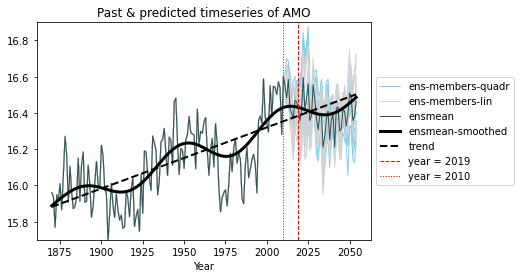

In [14]:
# generate time array
t_arr = np.arange(1870,1870+len(ensembles[0,0,:]),1)

# plot all ensemble members 
for i in range(len(ensembles2[:,0,0])):
    if i == 0: 
        plt.plot(t_arr, ensembles2[i,enscase,:], linewidth=1, color='skyblue', label = 'ens-members-quadr')
    else:
        plt.plot(t_arr, ensembles2[i,enscase,:], linewidth=1, color='skyblue')
for i in range(len(ensembles[:,0,0])):
    if i == 0: 
        plt.plot(t_arr, ensembles[i,enscase,:], linewidth=1, color='lightgrey', label = 'ens-members-lin')
    else:
        plt.plot(t_arr, ensembles[i,enscase,:], linewidth=1, color='lightgrey')

# plot ensemble mean
plt.plot(t_arr, ensmean2[enscase,:], color='darkslategrey', linewidth = 1, label = 'ensmean')        
# plot ensemble mean but smoothed
plt.plot(t_arr, ensmean_filt, color='k', linewidth = 3, label = 'ensmean-smoothed')

# plot trend
plt.plot(t_arr, trend, color='k', linewidth = 2, linestyle='dashed', label = 'trend')

# add a vertical line at 2019/2014 where past data stops and prediction begins (yrlast)
# also add the first year where we start predictions (yrfirst)
# both are defined above!
plt.axvline(x=yrlast, color='red', linewidth = 1, linestyle='dashed', label='year = ' + str(yrlast))
plt.axvline(x=yrfirst, color='red', linewidth = 1, linestyle='dotted', label='year = ' + str(yrfirst))

if PredictandName.find('Tsfc')>=0: 
    if PredictandName.find('Glob')>=0:
        plt.ylim(-0.5,1.5)
    else:
        plt.ylim(-3,3)
elif PredictandName.find('PrecipSEU')>=0:
    plt.ylim(1.5e-5,4.e-5)
elif PredictandName.find('PrecipNEU')>=0:
    plt.ylim(2.5e-5,5.e-5)
elif PredictandName.find('Ice')>=0:
    plt.ylim(0.08,0.17)
elif PredictandName.find('NAO')>=0:
    plt.ylim(-2.5,2.5)
else: # AMO
    plt.ylim(15.7,16.9)

# set up some labels
plt.title('Past & predicted timeseries of ' + PredictandName)
plt.xlabel('Year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# PLOT

#### (3) Plot correlation skill score and RMSE

 (for data prediction of 2019+ for the case with quadratically detrended sea-ice)

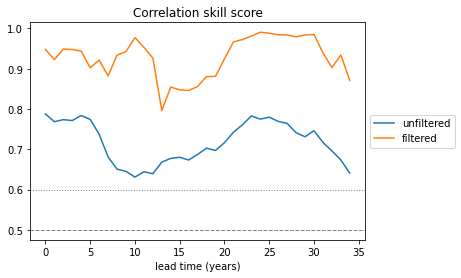

In [15]:
plt.plot(corrs[1,:],label = 'unfiltered')
plt.plot(corrsfilt[1,:], label = 'filtered')
plt.axhline(y=0.5,color='grey',linestyle='dashed',linewidth=1)
plt.axhline(y=0.6,color='grey',linestyle='dotted',linewidth=1)
plt.title('Correlation skill score')
plt.xlabel('lead time (years)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

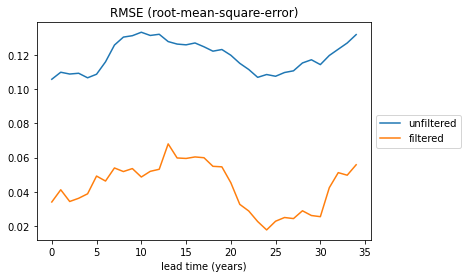

In [16]:
plt.plot(rmse[1,:],label = 'unfiltered')
plt.plot(rmsefilt[1,:],label = 'filtered')
plt.title('RMSE (root-mean-square-error)')
plt.xlabel('lead time (years)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))